In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

/Users/rayanedakhlaoui/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# 1. Loading the data

In [4]:
train_data, test_data = tf.keras.datasets.mnist.load_data(path="mnist.npz")
x_train = train_data[0].reshape(-1,784).astype(float) / 255
y_train = train_data[1]

label is 1


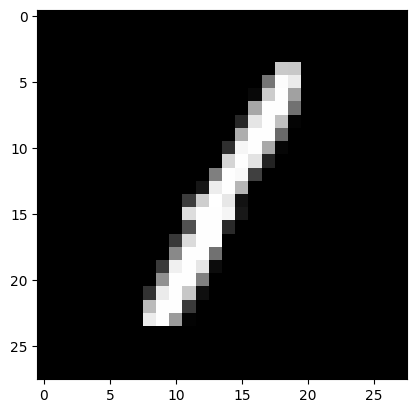

In [5]:
# exploring the data
i = np.random.randint(y_train.size)

print("label is", y_train[i])
plt.imshow(train_data[0][i], cmap='gray')

# 2. Building the model

We use Keras to build a fully-connected neural network.

For more details, see https://keras.io/guides/training_with_built_in_methods/

In [6]:
# source : https://keras.io/guides/training_with_built_in_methods/

def build_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(32, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(32, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
    return model

model = build_model()

loss = keras.losses.sparse_categorical_crossentropy

model.summary()

Model: "mnist_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ digits (InputLayer)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,506 (103.54 KB)

 Trainable params: 26,506 (103.54 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# untrained model
predicted_probas = model(x_train)
y_pred = np.argmax(predicted_probas, 1) # the prediction is the class with highest probability
y_pred[0:30]

array([5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 7, 8, 5, 5, 8, 5, 5, 5, 5, 5,
       5, 5, 5, 8, 5, 5, 5, 5])

In [8]:
# what we would like to get
y_train[0:30]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7], dtype=uint8)

# 3. Computing gradients

We are now going to implement the stochastic gradient method using the Keras functionalities.

First, we need to understand how to compute gradients using auto-differentation (also called **backpropagation**).

In [9]:
# Source: https://keras.io/guides/writing_a_custom_training_loop_in_tensorflow/

# Example of gradient computation using automatic differentiation

# selecting a batch
x_train_batch = x_train[:8]
y_train_batch = y_train[:8]

# Open a GradientTape to record the operations run
# during the forward pass, which enables auto-differentiation.
with tf.GradientTape() as tape:
        # Run the forward pass of the layer.
        # The operations that the layer applies
        # to its inputs are going to be recorded
        # on the GradientTape.

        logits = model(x_train_batch)  # Logits for this minibatch (the logits are the name we give to the Neural Network output)

        # Compute the loss value for this minibatch.
        loss_value = loss(y_train_batch, logits)

# Use the gradient tape to automatically retrieve
# the gradients of the trainable variables with respect to the loss.
grad = tape.gradient(loss_value, model.trainable_weights)

We also define two important helper functions.

In [10]:
## update the weights by adding real_factor * update
def update_weights(model, update, real_factor = 1.):
    new_weights = model.trainable_weights.copy()

    # iterate over all layers
    for i in range(len(new_weights)):
        new_weights[i] = new_weights[i] + real_factor * update[i]

    model.set_weights(new_weights)


# Evaluate model
def mean_loss(model, X, Y):
    logits = model(X)
    return np.mean(loss(Y, logits))

In [11]:
# evaluating the train loss on the whole dataset
# this is a costly operation, use sparsely
mean_loss(model, x_train, y_train)

2.3235319

# 4. Training the model

### Question 4.1 How many optimization variables are we going to train using this model?
##### Il y'a 26,506 trainable parameters.

In [12]:
#Question 5.1: SGD
def SGD(model, x_train, y_train, learning_rate, epochs=1, batch_size=1):
    dataset_size = x_train.shape[0]
    loss_iterations = []
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        indices = np.arange(dataset_size)
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        for start_idx in range(0, dataset_size, batch_size):
            end_idx = min(start_idx + batch_size, dataset_size)
            x_batch = x_train[start_idx:end_idx]
            y_batch = y_train[start_idx:end_idx]

            with tf.GradientTape() as tape:
                logits = model(x_batch)
                loss_value = loss(y_batch, logits)
                loss_iterations.append(np.mean(loss_value))
            grads = tape.gradient(loss_value, model.trainable_weights)
            update_weights(model, grads, -learning_rate)

        # Optionally, print the loss at the end of each epoch
        train_loss = mean_loss(model, x_train, y_train)
        print(f"Training loss: {train_loss:.4f}")
    return loss_iterations


In [13]:
# initialize model
model = build_model()

# Charger les données MNIST
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

x_test = test_images.reshape(-1, 784).astype(float) / 255.0
y_test = test_labels

# Hyperparamètres
learning_rate = 0.01
epochs = 5
batch_size = 32

# run SGD
SGD(model, x_train, y_train, learning_rate, epochs=epochs, batch_size=batch_size)

# Prédictions sur l'ensemble de test
test_logits = model.predict(x_test)
test_predictions = np.argmax(test_logits, axis=1)

# Calcul de l'accuracy
accuracy = np.mean(test_predictions == y_test)
print(f"Test accuracy: {accuracy * 100:.2f}%")

Epoch 1/5
Training loss: 0.1707
Epoch 2/5
Training loss: 0.1352
Epoch 3/5
Training loss: 0.1539
Epoch 4/5
Training loss: 0.0898
Epoch 5/5
Training loss: 0.0870
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Test accuracy: 96.08%


In [14]:
#Différents learning rates
batch_size=32
model_lr_1 = build_model()
loss_iterations_lr_1 = SGD(model_lr_1, x_train, y_train, learning_rate=0.1, epochs=1, batch_size = batch_size)
model_lr_01 = build_model()
loss_iterations_lr_01 = SGD(model_lr_01, x_train, y_train, learning_rate=0.01, epochs=1, batch_size = batch_size)
model_lr_001 = build_model()
loss_iterations_lr_001 = SGD(model_lr_001, x_train, y_train, learning_rate=0.001, epochs=1, batch_size = batch_size)

Epoch 1/1
Training loss: 2.3107
Epoch 1/1
Training loss: 0.1689
Epoch 1/1
Training loss: 0.2568


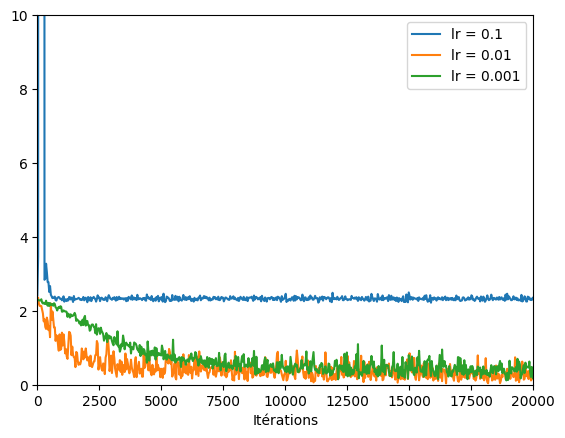

In [15]:
plt.plot([i for i in range(0, len(x_train), batch_size)],loss_iterations_lr_1,label='lr = 0.1')
plt.plot([i for i in range(0, len(x_train), batch_size)],loss_iterations_lr_01,label='lr = 0.01')
plt.plot([i for i in range(0, len(x_train), batch_size)],loss_iterations_lr_001,label='lr = 0.001')
plt.xlim(0, 20000)
plt.ylim(0, 10)
plt.xlabel("Itérations")
plt.legend()
plt.show()

### Question 5.2

D'après la formule de l'espérance de convergence, plus on augmente le learning rate $\gamma$ plus on converge rapidement mais plus on a un palier élevé

In [16]:
print(f'Le mean-loss final pour une époque avec un lr de 0.01 est : {loss_iterations_lr_01[-1]}')

Le mean-loss final pour une époque avec un lr de 0.01 est : 0.11504440009593964


In [17]:
print(f'Le mean-loss final pour 5 époques avec un lr de 0.01 est : {mean_loss(model, x_train, y_train)}')

Le mean-loss final pour 5 époques avec un lr de 0.01 est : 0.08703245967626572


### Question 6.1
On obtient effectivement de meilleures performances avec 5 époques qu'avec une seule pour un même learning rate

### Question 6.2 et 6.3
déjà faites précédemment

In [ ]:
x_test = test_data[0].reshape(-1,784).astype(float) / 255
y_test = test_data[1]
print(f'Le mean-loss final pour 5 époques avec un lr de 0.01 est : {mean_loss(model, x_test, y_test)}')

Le mean-loss final pour 5 époques avec un lr de 0.01 est : 0.1725645810365677


Les performances sont logiquement moins bonnes sur le test set que le train set mais on a une bonne précision de prédiction